<a href="https://colab.research.google.com/github/cicattzo/mit_advanced_nlp/blob/main/HA2_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this notebook, you will find code scaffolding for the seq2seq part of Homework 3 (code for the trees section of the assignment is released in another notebook). There are certain parts of the scaffolding marked with `# Your code here` comments where you can fill in code to perform the specified tasks. After implementing the methods in this notebook, you will need to design and perform experiments to evaluate each method and respond to the questions in the Homework 3 handout (available on Canvas). You should be able to complete this assignment without changing any of the scaffolding code, just writing code to fill in the scaffolding and run experiments.

# Set up dependencies and data

Let's use google drive to save our trained models to (so that we don't have to retrain them seventeen times).

In [41]:
from google.colab import drive 
drive.mount("/content/drive")

MODEL_FOLDER = "/content/drive/My Drive/mit-6864/hw3"
!mkdir -p "/content/drive/My Drive/mit-6864/hw3"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
%%bash
git clone https://github.com/mit-6864/hw3.git
mkdir -p /content/hw3/data

pip install sacrebleu

fatal: destination path 'hw3' already exists and is not an empty directory.


In [43]:
import sys
sys.path.append("/content/hw3")

import lab_utils

import torch 
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Part 1: Sequence-to-Sequence Model

In this lab, we will explore RNN-based sequence-to-sequence (seq2seq) models to perform machine translation (MT).

*   **Task:** translate from Vietnamese to English
*   **Model:** RNN-based encoder-decoder
*   **Data:** Vietnamese-English dataset from IWSLT'15


Implementation Tasks:
1. Data Preprocessing (done by TAs)
2. **Encoder** 
3. **Decoder**
4. EncoderDecoder (done by TAs)
5. Generator (done by TAs)
6. Training (done by TAs)
7. **Greedy Decoding**
8. Testing via BLEU (done by TAs)


## Section 1: Data Preprocessing

No need to write any code in this section. But you are encouraged to read through this part to understand the data.



### Download data
First, we download the dataset and put it in the `/content/hw3/data` folder.

In [44]:
# Download data
DATA_DIR = "/content/hw3/data"

!wget -nv -O "$DATA_DIR/train.en" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
!wget -nv -O "$DATA_DIR/train.vi" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
!wget -nv -O "$DATA_DIR/tst2013.en" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en
!wget -nv -O "$DATA_DIR/tst2013.vi" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi
!wget -nv -O "$DATA_DIR/vocab.en" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en
!wget -nv -O "$DATA_DIR/vocab.vi" https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi


2021-04-04 15:04:40 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en [13603614/13603614] -> "/content/hw3/data/train.en" [1]
2021-04-04 15:04:42 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi [18074646/18074646] -> "/content/hw3/data/train.vi" [1]
2021-04-04 15:04:42 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en [132264/132264] -> "/content/hw3/data/tst2013.en" [1]
2021-04-04 15:04:42 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi [183855/183855] -> "/content/hw3/data/tst2013.vi" [1]
2021-04-04 15:04:43 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en [139741/139741] -> "/content/hw3/data/vocab.en" [1]
2021-04-04 15:04:43 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi [46767/46767] -> "/content/hw3/data/vocab.vi" [1]


### Load the Data and Preprocess
We then load the sentences and vocab lists, only keeping sentences that do not exceed 48 words (50 with the EOS tags).

Number of training (src, trg) sentence pairs: 108748
Number of validation (src, trg) sentence pairs: 12083
Number of testing (src, trg) sentence pairs: 1139
Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 7711
Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 17193
Training sentence avg. length: 20 
Training sentence length at 95-percentile: 42
Training sentence length distribution (x-axis is length range and y-axis is count):



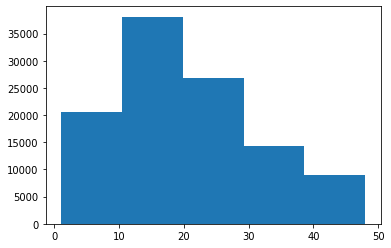

Example Vietnamese input: ['Adam', 'Sadowsky', 'dàn', 'dựng', '1', 'video', 'âm', 'nhạc', 'hiện', 'tượng', '.']
Its target English output: ['Adam', 'Sadowsky', ':', 'How', 'to', 'engineer', 'a', 'viral', 'music', 'video']


In [45]:
from lab_utils import read_vocab_file, read_sentence_file, filter_data, show_some_data_stats

src_vocab_set = read_vocab_file("vocab.vi")
trg_vocab_set = read_vocab_file("vocab.en")

train_src_sentences_list = read_sentence_file("train.vi")
train_trg_sentences_list = read_sentence_file("train.en")
assert len(train_src_sentences_list) == len(train_trg_sentences_list)

test_src_sentences_list = read_sentence_file("tst2013.vi")
test_trg_sentences_list = read_sentence_file("tst2013.en")
assert len(test_src_sentences_list) == len(test_trg_sentences_list)

# Filter out sentences over 48 words long
MAX_SENT_LENGTH = 48
MAX_SENT_LENGTH_PLUS_SOS_EOS = 50

train_src_sentences_list, train_trg_sentences_list = filter_data(
    train_src_sentences_list, train_trg_sentences_list, MAX_SENT_LENGTH)
test_src_sentences_list, test_trg_sentences_list = filter_data(
    test_src_sentences_list, test_trg_sentences_list, MAX_SENT_LENGTH)

# We take 10% of training data as validation set.
num_val = int(len(train_src_sentences_list) * 0.1)
val_src_sentences_list = train_src_sentences_list[:num_val]
val_trg_sentences_list = train_trg_sentences_list[:num_val]
train_src_sentences_list = train_src_sentences_list[num_val:]
train_trg_sentences_list = train_trg_sentences_list[num_val:]

show_some_data_stats(train_src_sentences_list, val_src_sentences_list, 
                     test_src_sentences_list, train_trg_sentences_list,
                     src_vocab_set, trg_vocab_set)

### Define Dataset class
Here is the class for our dataset. We build off of the Dataset class. The IDs that we reserve might be useful later.

In [46]:
import torch
from torch.utils import data

# These IDs are reserved.
PAD_INDEX = 0
UNK_INDEX = 1
SOS_INDEX = 2
EOS_INDEX = 3


class MTDataset(data.Dataset):
  def __init__(self, src_sentences, src_vocabs, trg_sentences, trg_vocabs,
               sampling=1.):
    self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]
    self.trg_sentences = trg_sentences[:int(len(src_sentences) * sampling)]

    self.max_src_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS
    self.max_trg_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS

    self.src_vocabs = src_vocabs
    self.trg_vocabs = trg_vocabs

    self.src_v2id = {v : i for i, v in enumerate(src_vocabs)}
    self.src_id2v = {val : key for key, val in self.src_v2id.items()}
    self.trg_v2id = {v : i for i, v in enumerate(trg_vocabs)}
    self.trg_id2v = {val : key for key, val in self.trg_v2id.items()}

  def __len__(self):
    return len(self.src_sentences)

  def __getitem__(self, index):
    src_sent = self.src_sentences[index]
    src_len = len(src_sent) + 2   # add <s> and </s> to each sentence
    src_id = []
    for w in src_sent:
      if w not in self.src_vocabs:
        w = '<unk>'
      src_id.append(self.src_v2id[w])
    src_id = ([SOS_INDEX] + src_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_src_seq_length - src_len))

    trg_sent = self.trg_sentences[index]
    trg_len = len(trg_sent) + 2
    trg_id = []
    for w in trg_sent:
      if w not in self.trg_vocabs:
        w = '<unk>'
      trg_id.append(self.trg_v2id[w])
    trg_id = ([SOS_INDEX] + trg_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_trg_seq_length - trg_len))

    return torch.tensor(src_id), src_len, torch.tensor(trg_id), trg_len

## **Section 2: Encoder**

First, for a high-level overview. Our seq2seq model will consist of an Encoder RNN and a Decoder RNN. We will first implement this with no attention mechanism between the encoder and decoder. The encoder aims to compress the information contained in the entire input sequence into a single vector and pass it to the decoder.

Here's a picture overview if you're a visual person.

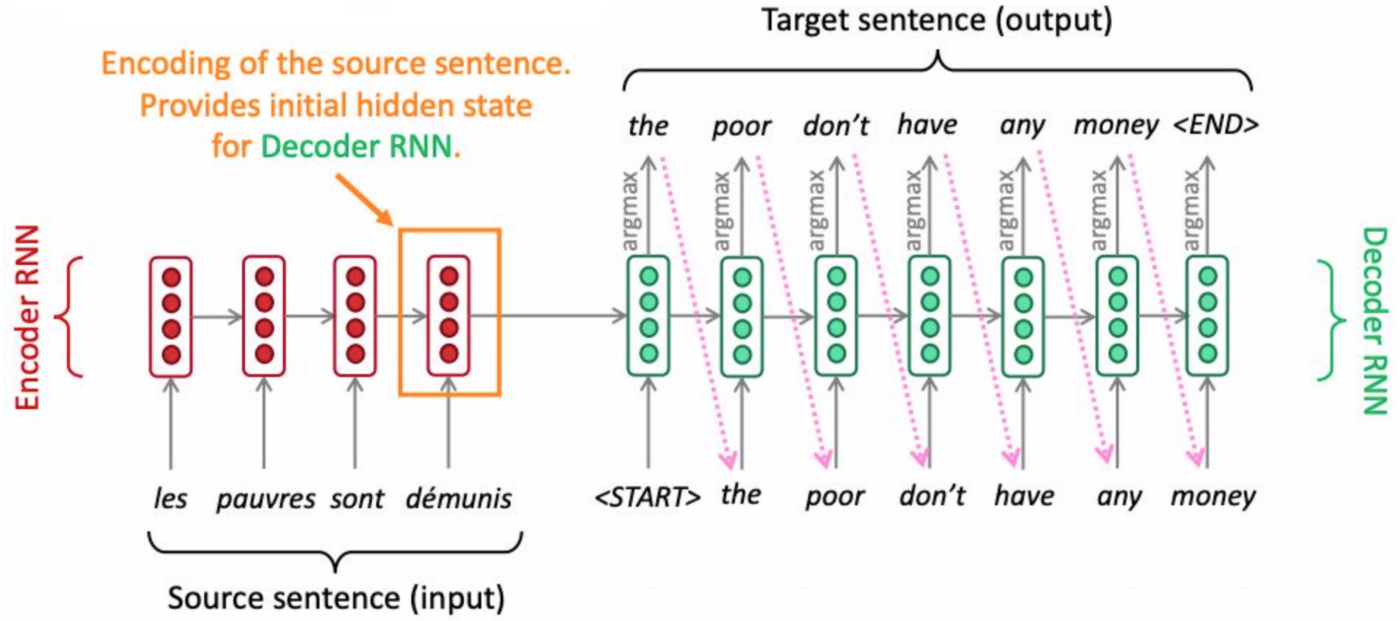

First let's implement the encoder, which in our case is just an RNN (feel free to use a GRU or try other cell types! and feel free to experiment with number of layers).

In [54]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, dropout=0.):
    """
    Inputs: 
      - `input_size`: an int representing the RNN input size.
      - `hidden_size`: an int representing the RNN hidden size.
      - `dropout`: a float representing the dropout rate during training. Note
          that for 1-layer RNN this has no effect since dropout only applies to
          outputs of intermediate layers.
    """
    
    super(Encoder, self).__init__()

    # --------- Your code here --------- #
    # feel free to use a pre-implemented pytorch GRU
    # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
    # self.num_layers = 1

    # self.embedding = nn.Embedding(input_size, hidden_size)

    self.rnn = nn.GRU(input_size, hidden_size, 1, 
                          batch_first=True, dropout=dropout)

    
    # --------- Your code ends --------- #

  def forward(self, inputs, lengths):
    """
    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of source
          sentences.
      - `lengths`: a 1d-tensor of shape (batch_size,) representing the sequence
          lengths of `inputs`.

    Returns:
      - `outputs`: a 3d-tensor of shape
        (batch_size, max_seq_length, hidden_size).
      - `finals`: a 3d-tensor of shape (num_layers, batch_size, hidden_size).

      Hint: `outputs` and `finals` are both standard GRU outputs.
    """
    # outputs = None
    # finals = None

    packed = pack_padded_sequence(inputs, lengths.cpu(), batch_first=True, enforce_sorted=False)
    output, final = self.rnn(packed)
    output, _ = pad_packed_sequence(output, batch_first=True, total_length = MAX_SENT_LENGTH_PLUS_SOS_EOS)
    
    # --------- Your code here --------- #
    # hint: you probably want to pack the inputs and outputs (see note below)
    #       https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html
    # hint2: given the shape of the inputs and outputs, 
    #        it might be helpful to specify batch_first=True (also in __init___)
    # hint3: MAX_SENT_LENGTH_PLUS_SOS_EOS is a global variable that exists if 
    #        you ever need to specify a total_length for outputs

    # --------- Your code ends --------- #

    return output, final

##### Note about packing & padding:

**Why we pad:** to be able to batch sequences of different lengths

**Why we pack:** to be able do computations with padded sequences more efficiently 

The second answer on this [stackoverflow article](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch) is very helpful.

## **Section 3: Decoder**

Here you will implement a decoder RNN.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string `<SOS>` token, and the first hidden state is the context vector (the encoder’s last hidden state).

In [64]:
class Decoder(nn.Module):
  """An RNN decoder without attention."""

  def __init__(self, input_size, hidden_size, dropout=0.):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
    """
    super(Decoder, self).__init__()

    # --------- Your code here --------- #
    # hint: you need more layers than the encoder
    #       again, feel free to use pytorch implemetnations
    #       https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
    
    # self.embedding = nn.Embedding(input_size, hidden_size)

    # self.rnn = nn.GRU(hidden_size, hidden_size, 1, batch_first=True, dropout=dropout)

    self.rnn = nn.GRU(input_size, hidden_size, 1, batch_first=True, dropout=dropout)

    self.bridge = nn.Linear(hidden_size, hidden_size, bias=True)

    self.dropout_layer = nn.Dropout(p=dropout)

    self.out = nn.Linear(hidden_size, input_size, bias = False)



  def forward_step(self, prev_embed, hidden):
    """Helper function for forward below:
       Perform a single decoder step (1 word).

       Inputs:
      - `prev_embed`: a 3d-tensor of shape (batch_size, 1, embed_size)
          representing the padded embedded word vectors at this step in training
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the current hidden state.

      Returns:
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
          representing the current decoder hidden state.
      - `pre_output`: a 3d-tensor of shape (batch_size, 1, hidden_size)
          representing the total decoder output for one step
    """
    # pre_output = None
    # --------- Your code here --------- #
    # embed = self.embedding(prev_embed)
    pre_output, hidden = self.rnn(prev_embed, hidden)
    # pre_output = self.dropout_layer(pre_output)
    # pre_output = torch.cat([prev_embed, pre_output], dim=2)
    # pre_output = self.bridge(pre_output)
    pre_output = self.dropout_layer(pre_output)
    pre_output = self.out(pre_output)
    # --------- Your code ends --------- #
    return hidden, pre_output

  def forward(self, inputs, encoder_finals, hidden=None, max_len=None):
    """Unroll the decoder one step at a time.

    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of target
          sentences (for teacher-forcing during training).
      - `encoder_finals`: a 3d-tensor of shape
          (num_enc_layers, batch_size, hidden_size) representing the final
          encoder hidden states used to initialize the initial decoder hidden
          states.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the value to be used to initialize the initial decoder hidden states.
          If None, then use `encoder_finals`.
      - `max_len`: an int representing the maximum decoding length.

    Returns:
      - `outputs`: a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the raw
          decoder outputs (before converting to a `trg_vocab_size`-dim vector).
          We will convert it later in a `Generator` below.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
          representing the last decoder hidden state.
    """

    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = inputs.size(1)

    # Initialize decoder hidden state.
    if hidden is None:
      hidden = self.init_hidden(encoder_finals)

    # outputs = None
    
    # --------- Your code here --------- #

    # Unroll the decoder RNN for `max_len` steps.
    # hint: use the above helper function forward_step that 
    #       performs a single decoder step (1 word).

    outputs = None

    for i in range(max_len):
       prev_emb = inputs[:, i].unsqueeze(1)
      #  print(prev_emb)
       hidden, output = self.forward_step(prev_emb, hidden)
       if outputs == None:
         outputs=output
       else:
         outputs = torch.cat([outputs, output], dim = 1)

    
    # --------- Your code ends --------- #

    return hidden, outputs

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    decoder_init_hiddens = torch.tanh(self.bridge(encoder_finals))

    return decoder_init_hiddens

We have defined a high level encoder-decoder class to wrap up sub-models, including encoder, decoder, generator, and src/trg embeddings.

You don't need to write code here, but please try to understand what is going on!

In [49]:
class EncoderDecoder(nn.Module):
  """A standard Encoder-Decoder architecture without attention.
  """
  def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: a `Decoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super(EncoderDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and target sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths)
    del encoder_hiddens   # unused
    return self.decode(encoder_finals, trg_ids[:, :-1])

  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)
    
  def decode(self, encoder_finals, trg_ids, decoder_hidden=None):
    return self.decoder(self.trg_embed(trg_ids), encoder_finals, decoder_hidden)

It simply projects the pre-output layer (x in the forward function below) to obtain the output layer, so that the final dimension is the target vocabulary size.

In [50]:
class Generator(nn.Module):
  """Define standard linear + softmax generation step."""
  def __init__(self, hidden_size, vocab_size):
    super(Generator, self).__init__()
    self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

Wahoo! Now you have a working EncoderDecoder model! If you scroll down to the training section, you can train your model and try it out on the dataset. (Warning, it performs pretty miserably without Attention :'( )

## **Section 4: Training**

We provide training and testing scripts here. You might need to adapt them to fit your model implementation.

Apply the dataloader to the MTDataset, which is defined in `lab_utils.py`. Dataloader provides a convenient way to iterate through the whole dataset.




In [51]:
from torch.utils import data

batch_size = 128

# You can try on a smaller training set by setting a smaller `sampling`.
train_set = MTDataset(train_src_sentences_list, src_vocab_set,
                      train_trg_sentences_list, trg_vocab_set, sampling=1.)
train_data_loader = data.DataLoader(train_set, batch_size=batch_size,
                                    num_workers=8, shuffle=True)

val_set = MTDataset(val_src_sentences_list, src_vocab_set,
                    val_trg_sentences_list, trg_vocab_set, sampling=1.)
val_data_loader = data.DataLoader(val_set, batch_size=batch_size, num_workers=8,
                                  shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The main functions for training, here we use perplexity to evaluate the performance of the model. Although we provide the training scripts here, we strongly encoureage you to go through and understand the procedure.

In [52]:
import math


class SimpleLossCompute:
  """A simple loss compute and train function."""

  def __init__(self, generator, criterion, opt=None):
    self.generator = generator
    self.criterion = criterion
    self.opt = opt

  def __call__(self, x, y, norm):
    x = self.generator(x)
    loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                          y.contiguous().view(-1))
    loss = loss / norm

    if self.opt is not None:  # training mode
      loss.backward()          
      self.opt.step()
      self.opt.zero_grad()

    return loss.data.item() * norm


def run_epoch(data_loader, model, loss_compute, print_every):
  """Standard Training and Logging Function"""

  total_tokens = 0
  total_loss = 0

  for i, (src_ids_BxT, src_lengths_B, trg_ids_BxL, trg_lengths_B) in enumerate(data_loader):
    # We define some notations here to help you understand the loaded tensor
    # shapes:
    #   `B`: batch size
    #   `T`: max sequence length of source sentences
    #   `L`: max sequence length of target sentences; due to our preprocessing
    #        in the beginning, `L` == `T` == 50
    # An example of `src_ids_BxT` (when B = 2):
    #   [[2, 4, 6, 7, ..., 4, 3, 0, 0, 0],
    #    [2, 8, 6, 5, ..., 9, 5, 4, 3, 0]]
    # The corresponding `src_lengths_B` would be [47, 49].
    # Note that SOS_INDEX == 2, EOS_INDEX == 3, and PAD_INDEX = 0.

    src_ids_BxT = src_ids_BxT.to(device)
    src_lengths_B = src_lengths_B.to(device)
    trg_ids_BxL = trg_ids_BxL.to(device)

    del trg_lengths_B   # unused

    _, output = model(src_ids_BxT, trg_ids_BxL, src_lengths_B)

    loss = loss_compute(x=output, y=trg_ids_BxL[:, 1:],
                        norm=src_ids_BxT.size(0))
    total_loss += loss
    total_tokens += (trg_ids_BxL[:, 1:] != PAD_INDEX).data.sum().item()

    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss: %f" % (i, loss / src_ids_BxT.size(0)))

  return math.exp(total_loss / float(total_tokens))


def train(model, num_epochs, learning_rate, print_every):
  # Set `ignore_index` as PAD_INDEX so that pad tokens won't be included when
  # computing the loss.
  criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Keep track of dev ppl for each epoch.
  dev_ppls = []

  for epoch in range(num_epochs):
    print("Epoch", epoch)

    model.train()
    train_ppl = run_epoch(data_loader=train_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, optim),
                          print_every=print_every)
        
    model.eval()
    with torch.no_grad():      
      dev_ppl = run_epoch(data_loader=val_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, None),
                          print_every=print_every)
      print("Validation perplexity: %f" % dev_ppl)
      dev_ppls.append(dev_ppl)
        
  return dev_ppls

The main function to perform training. First let's train the vanilla seq2seq model (fyi, it took ~10 minutes to go through 10 epochs using colab gpus; using default parameters, epoch 0 validation perplexity was 75ish and epoch 9 was 36ish).

Feel free to save the model more frequently (by adding a couple of lines in train() above) or change the path that it is saved at.

### EncoderDecoder Training

Epoch 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch Step: 0 Loss: 155.477051
Epoch Step: 100 Loss: 100.230499
Epoch Step: 200 Loss: 88.908966
Epoch Step: 300 Loss: 84.711548
Epoch Step: 400 Loss: 84.814056
Epoch Step: 500 Loss: 83.227112
Epoch Step: 600 Loss: 82.152069
Epoch Step: 700 Loss: 81.907967
Epoch Step: 800 Loss: 78.361549
Validation perplexity: 74.397400
Epoch 1
Epoch Step: 0 Loss: 77.026093
Epoch Step: 100 Loss: 78.634079
Epoch Step: 200 Loss: 86.709091
Epoch Step: 300 Loss: 68.955055
Epoch Step: 400 Loss: 73.309258
Epoch Step: 500 Loss: 67.720238
Epoch Step: 600 Loss: 69.219177
Epoch Step: 700 Loss: 74.263184
Epoch Step: 800 Loss: 72.806816
Validation perplexity: 53.624774
Epoch 2
Epoch Step: 0 Loss: 67.108421
Epoch Step: 100 Loss: 68.013016
Epoch Step: 200 Loss: 66.340195
Epoch Step: 300 Loss: 61.691956
Epoch Step: 400 Loss: 72.754745
Epoch Step: 500 Loss: 69.529922
Epoch Step: 600 Loss: 69.533447
Epoch Step: 700 Loss: 65.424316
Epoch Step: 800 Loss: 64.500816
Validation perplexity: 45.762569
Epoch 3
Epoch Step: 0 Los

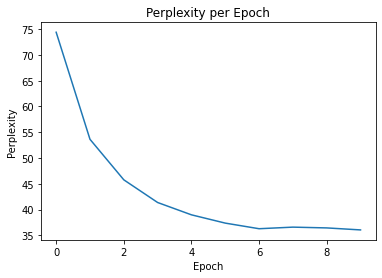

In [101]:
# Hyperparameters for contructing the encoder-decoder model.
embed_size = 256   # Each word will be represented as a `embed_size`-dim vector.
hidden_size = 256  # RNN hidden size.
dropout = 0.2

pure_seq2seq = EncoderDecoder(
    encoder=Encoder(embed_size, hidden_size, dropout=dropout),
    decoder=Decoder(embed_size, hidden_size, dropout=dropout),
    src_embed=nn.Embedding(len(src_vocab_set), embed_size),
    trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
    generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

train_model = True
if train_model:
  # Start training. The returned `dev_ppls` is a list of dev perplexity for each
  # epoch.
  pure_dev_ppls = train(pure_seq2seq, num_epochs=10, learning_rate=1e-3,
                        print_every=100)
  
  torch.save(pure_seq2seq.state_dict(), MODEL_FOLDER+"/" + "pure_seq2seq.pt")

  # Plot perplexity
  lab_utils.plot_perplexity(pure_dev_ppls)
else:
  pure_seq2seq.load_state_dict(torch.load(MODEL_FOLDER+"/" + "pure_seq2seq.pt"))

## Section 5: Decoding

Now that we have a trained model, the next task is to decode the model output. This is non-trivial. For the sake of simplicity, we'll go for the naive, greedy approach. 

For greedy decoding, you will generate (or "decode") the target sentence by simply taking the argmax over the decoder output at each time step.

In [102]:
from numpy import argmax

def greedy_decode(model, src_ids, src_lengths, max_len, sos_index=SOS_INDEX, eos_index=EOS_INDEX):
  """Greedily decode a sentence for EncoderDecoder. Make sure to chop off the 
     EOS token!"""

  with torch.no_grad():
    _, encoder_final = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)
    trg_mask = torch.ones_like(prev_y)

  output = []
  hidden = None

  # encoder_finals, trg_ids, decoder_hidden=None)
  
  # --------- Your code here --------- #
  for i in range(max_len):
    with torch.no_grad():
      hidden, pre_output = model.decode(encoder_final, 
                                        prev_y, 
                                        hidden)
      
      prob = model.generator(pre_output[:, -1])

    _, next_word = torch.max(prob, dim=1)
    # print(next_word)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).type_as(src_ids).fill_(next_word)

  output = np.array(output)

  if eos_index is not None:
    first_eos = np.where(output==eos_index)[0]
    if len(first_eos) > 0:
      output = output[:first_eos[0]]   

  # --------- Your code ends --------- #

  return output

Let's look at three examples for the EncoderDecoder model. Feel free to play around here, printing out more examples.




In [103]:
example_set = MTDataset(val_src_sentences_list, src_vocab_set,
                        val_trg_sentences_list, trg_vocab_set)
example_data_loader = data.DataLoader(example_set, batch_size=1, num_workers=1,
                                      shuffle=False)


print("EncoderDecoder Results:")
lab_utils.print_examples(pure_seq2seq, src_vocab_set, trg_vocab_set,
                         example_data_loader, greedy_decode, n=3)

EncoderDecoder Results:
Example #1
Src :  Khoa học đằng sau một tiêu đề về khí hậu
Trg :  Rachel <unk> : The science behind a climate headline
Pred:  <unk> <unk> in the middle of the <unk> .

Example #2
Src :  Tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo .
Trg :  I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .
Pred:  I want to show you a lot of the most exciting insights in the world that you &apos;ve been able to do with this research .

Example #3
Src :  Có những dòng trông như thế này khi bàn về biến đổi khí hậu , và như thế này khi nói về chất lượng không khí hay khói bụi .
Trg :  <unk> that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .
Pred:  There &apos;s a lot of things like that , like , <unk> , or <unk> , or <unk> , or th

## Section 6: Testing
Compute the BLEU score on the test set. BLEU score is a standard measure to evaluate the translation results. For further details, you can refer to [this](https://en.wikipedia.org/wiki/BLEU) link. (The TAs' preliminary implementation of EncoderDecoder gets a BLEU score of around 6).

In [104]:
import sacrebleu
from tqdm import tqdm

def compute_BLEU(model, data_loader, decoder, trg_vocab_set):

  bleu_score = []

  model.eval()
  for src_ids, src_lengths, trg_ids, _ in tqdm(data_loader):
    result = decoder(model, src_ids.to(device), src_lengths.to(device),
                         max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    
    # remove <s>
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

    pred = " ".join(lab_utils.lookup_words(result, vocab=trg_vocab_set))
    targ = " ".join(lab_utils.lookup_words(trg_ids, vocab=trg_vocab_set))

    bleu_score.append(sacrebleu.raw_corpus_bleu([pred], [[targ]], .01).score)

  return bleu_score

In [105]:
test_set = MTDataset(test_src_sentences_list, src_vocab_set,
                     test_trg_sentences_list, trg_vocab_set, sampling=1.)
test_data_loader = data.DataLoader(test_set, batch_size=1, num_workers=8,
                                   shuffle=False)

print('BLEU score without Attention: %f' % (np.mean(compute_BLEU(pure_seq2seq, 
                                            test_data_loader,
                                            greedy_decode, trg_vocab_set))))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1139/1139 [00:29<00:00, 38.40it/s]

BLEU score without Attention: 6.187400
